In [ ]:
## Notebook env: brian_script_env (R kernel)
## This notebook starts requires archr_obtaining_chromatin_matrices.ipynb to be run first

In [1]:
library(ggplot2)
library(ggpubr)
library(Matrix)
library(sparseMatrixStats)
library(ggforce)
library(dplyr)
library(tidyr)
library(pbapply)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [2]:
### load data ###
## get genes used in CRISPRi and CRISPRa scRNAseq analysis ##
CRISPRi_scRNAseq_genes = readRDS('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/CV_gene_median_aboveorequalto1_normalized_mtx_cc_regressed_CRISPRi_used_genes.rds')
#CRISPRa_scRNAseq_genes = readRDS('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRa_second_repeat_screen_deep_sequenced/heterogeneity/CV_gene_median_aboveorequalto1_normalized_mtx_cc_regressed_CRISPRa_used_genes.rds')

## get gene scores mtx ##
txnhet_archr_macs2_gene_scores_mtx = readRDS(file = '/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/archr_analysis/txnhet_archr_macs2_gene_scores_mtx.rds')
txnhet_archr_macs2_gene_scores_meta = readRDS(file = '/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/archr_analysis/txnhet_archr_macs2_gene_scores_meta.rds')

In [3]:
### CRISPRi matrix filtering ###
txnhet_archr_macs2_gene_scores_CRISPRi_meta = txnhet_archr_macs2_gene_scores_meta %>% filter(endsWith(Sample, 'Ci-1') | endsWith(Sample, 'Ci-2'))
txnhet_archr_macs2_gene_scores_CRISPRi_mtx = txnhet_archr_macs2_gene_scores_mtx[rownames(txnhet_archr_macs2_gene_scores_mtx) %in% CRISPRi_scRNAseq_genes, rownames(txnhet_archr_macs2_gene_scores_CRISPRi_meta)]
colnames(txnhet_archr_macs2_gene_scores_CRISPRi_meta)[colnames(txnhet_archr_macs2_gene_scores_CRISPRi_meta) == 'Sample'] = 'guide'

## combine replicates ##
txnhet_archr_macs2_gene_scores_CRISPRi_meta$guide = stringr::str_sub(txnhet_archr_macs2_gene_scores_CRISPRi_meta$guide, 1, -3)

## rename for analysis below ##

filtered_meta_data = txnhet_archr_macs2_gene_scores_CRISPRi_meta
filtered_raw_mtx = txnhet_archr_macs2_gene_scores_CRISPRi_mtx

In [4]:
## cells per guide count
guides = unique(filtered_meta_data$guide)

cells_per_guide = vector()
for (i in 1:length(guides)){
    cells_per_guide[i] = length(which(filtered_meta_data$guide == guides[i]))
}

cell_gd_count = data.frame(guide_name = guides, cell_count = cells_per_guide)

In [5]:
cell_gd_count

guide_name,cell_count
<fct>,<int>
RNF8-Ci,26288
MIS18A-Ci,14240
NTCi,8782


In [6]:
### divide expression mtx into a list of mtxs subsetted by guide

mtx_subsetter = function(guide_nm, matrix, meta_data){
    return(matrix[, meta_data$guide == guide_nm])}

guide_subsetted_data = pblapply(X = guides, FUN = mtx_subsetter, 
                                matrix = filtered_raw_mtx, meta_data = filtered_meta_data)

names(guide_subsetted_data) = guides

In [7]:
## control number of cells per guide to be equivalent
## throw out guides with < 3500 cells and for the remaining guides (all remain) sample 3500 cells without replacement
fixed_cell_count = 8000
guide_subsetted_data = guide_subsetted_data[cells_per_guide >= fixed_cell_count]
cells_to_discard = list()

set.seed(22)
for (i in 1:length(guide_subsetted_data)){
    idx_to_keep = sample(1:ncol(guide_subsetted_data[[i]]), fixed_cell_count, replace = FALSE)
    idx_to_discard = setdiff(1:ncol(guide_subsetted_data[[i]]), idx_to_keep)
    cells_to_discard[[i]] = colnames(guide_subsetted_data[[i]])[idx_to_discard]
    guide_subsetted_data[[i]] = guide_subsetted_data[[i]][,idx_to_keep]
}

cells_to_discard = unlist(cells_to_discard)

In [ ]:
## pseudo-bulk the matrix ##
guide_subsetted_data_pseudobulk = pblapply(X = guide_subsetted_data, FUN = function(x) sparseMatrixStats::rowMeans2(x))
guide_subsetted_data_means = guide_subsetted_data_pseudobulk
guide_subsetted_data_means = lapply(X = guide_subsetted_data_means, FUN = function(x) data.frame(gene = rownames(guide_subsetted_data[[1]]), mean = x))
saveRDS(guide_subsetted_data_means, '/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/post_archr_analysis/CRISPRi_means.rds')

## create dataframe of gene accessibility values for each guide ##
guide_identity_vector = unlist(mapply(FUN = rep, x = names(guide_subsetted_data_pseudobulk), times = as.numeric(sapply(guide_subsetted_data_pseudobulk, length)), SIMPLIFY = F),use.names = F)
df = data.frame(values = log2(unlist(guide_subsetted_data_pseudobulk, use.names = F)), guide = guide_identity_vector)
df$guide = factor(df$guide, levels = c(guides[3], guides[1:2]))
df = df %>% filter(!is.infinite(values))
saveRDS(df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/means_CRISPRi_violin_df.rds')

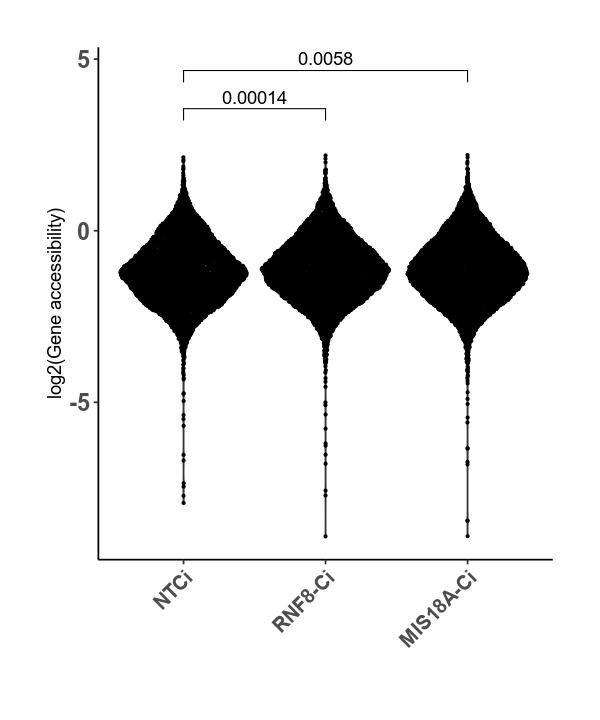

In [ ]:
## This shows there is more global gene accessibility in the RNF8-Ci and MIS18A-Ci guides than NTCi guide which is weird...

options(repr.plot.width = 5, repr.plot.height = 6)
library(ggforce)
#plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('random_NTCi'))]
comparisons = list(c('NTCi', 'RNF8-Ci'), c('NTCi', 'MIS18A-Ci'))
ggplot(df, aes(guide, values)) + ylab('log2(Gene accessibility)') + xlab('') +
  geom_violin(aes(fill = guide), position=position_dodge()) + #annotate("text", x = 1:length(plotted_guides), y = 3.5, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  geom_sina(position=position_dodge(), size = 0.5) + coord_cartesian(clip = 'off') + stat_compare_means(comparisons = comparisons, method = 't.test', label.y = 3, na.rm = T, step.increase = 0.1) + 
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1))

In [90]:
df %>% group_by(guide) %>% summarise(mean = 2^mean(values), sd = 2^sd(values))
## 5.8k genes

guide,mean,sd
<fct>,<dbl>,<dbl>
NTCi,0.4353224,1.910664
RNF8-Ci,0.4555573,1.890031
MIS18A-Ci,0.4501695,1.939568
